In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [4]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
from data.get_data import get_tubingen_pairs_dataset, get_synthetic_dataset, get_simulated_pairs_dataset
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [3]:
x, y, weight = get_synthetic_dataset(
    num_datasets=100,
    sample_size=100,
    func_string="mult_a",
    noise="normal"
)
input, output = x[1], y[1]
input = (input - input.mean(axis=0)[:, None]) / input.std(axis=0)[:, None]
output = (output - output.mean(axis=0)[:, None]) / output.std(axis=0)[:, None]

In [5]:
x, y, weight = get_simulated_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/sim_pairs/files'
)
input, output = x[8], y[8]
input = (input - input.mean(axis=0)[:, None]) / input.std(axis=0)[:, None]
output = (output - output.mean(axis=0)[:, None]) / output.std(axis=0)[:, None]

Load cause-effect pairs: 100%|██████████| 100/100 [00:00<00:00, 277.07it/s]


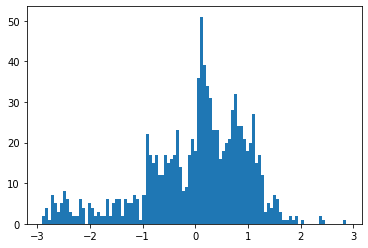

In [6]:
import matplotlib.pyplot as plt
import numpy as np


plt.hist(output[:, 0], bins=100)
plt.show()

In [7]:
input

array([[-1.98848036e+00],
       [ 1.42515433e-01],
       [-3.23048849e+00],
       [ 5.44803244e-01],
       [ 3.40605287e-01],
       [ 1.35887737e-01],
       [-2.97103041e+00],
       [-1.28074597e+00],
       [-1.48750678e+00],
       [-1.51880972e+00],
       [-3.69016200e-01],
       [ 1.90160576e+00],
       [-2.10779872e-02],
       [ 5.33869609e-01],
       [-4.51292396e-01],
       [-5.16303996e-01],
       [-3.30880475e-01],
       [ 3.11327068e-01],
       [ 5.62865611e-02],
       [-4.25121808e-01],
       [ 3.13378377e-01],
       [ 2.06021936e-01],
       [-1.71904286e+00],
       [-9.79401665e-01],
       [ 2.84717189e-01],
       [-1.05975398e+00],
       [ 6.08472731e-01],
       [-2.18721326e+00],
       [ 1.91412104e+00],
       [ 7.22611900e-01],
       [-1.08078773e+00],
       [-1.92973800e-01],
       [ 6.50355123e-02],
       [ 8.16244503e-01],
       [-1.94785789e-01],
       [ 6.93616585e-01],
       [-2.20460526e-01],
       [ 4.02960644e-01],
       [ 3.8

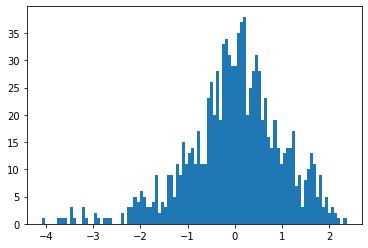

In [8]:
plt.hist(input[:, 0], bins=100)
plt.show()

In [9]:
input.mean()

-4.440892098500626e-19

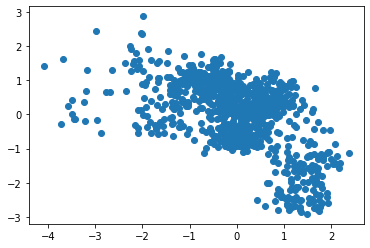

In [10]:
plt.scatter(input[:, 0], output[:, 0])
plt.show()

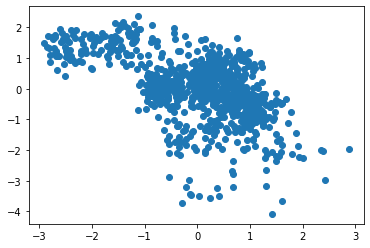

In [11]:
plt.scatter(output[:, 0], input[:, 0])
plt.show()

In [16]:
from gpflow.base import Parameter
from gpflow.utilities import positive




kernel_variance = 1
kernel_lengthscale = 1. / 4
# likelihood_variance = 1
likelihood_variance = Parameter( 1. / (10 ** 2), transform=positive(lower=1e-4))

rq_exp = gpflow.kernels.RationalQuadratic(lengthscales=[kernel_lengthscale])
sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[kernel_lengthscale])

linear_kernel = gpflow.kernels.Linear(variance=kernel_variance)

sq_exp.variance.assign(kernel_variance)

kernel = gpflow.kernels.Sum([rq_exp, linear_kernel, sq_exp])

m_gpr = gpflow.models.GPR(data=(input, output), kernel=kernel, mean_function=None)
m_gpr.likelihood.variance = likelihood_variance
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m_gpr.training_loss, m_gpr.trainable_variables, options=dict(maxiter=10000)
)

In [17]:
x_new = np.linspace(-2, 2, 1000)[:, None]
pred_f, var_f = m_gpr.predict_y(x_new)

In [18]:
from gpflow.utilities import print_summary
print_summary(m_gpr)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 6.448383016566082e-07 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.73414114]          │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].alpha     

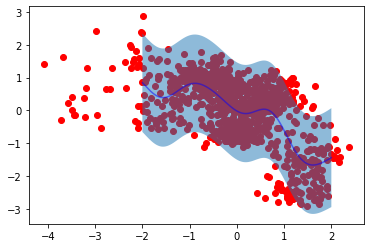

In [19]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.plot(x_new, pred_f, c='b', alpha=0.5)
plt.fill_between(x_new[:, 0], (pred_f + 2 * np.sqrt(var_f))[:, 0], (pred_f - 2 * np.sqrt(var_f))[:, 0], alpha=0.5)
plt.show()

In [20]:
 - m_gpr.log_marginal_likelihood().numpy()

1136.4480590425107

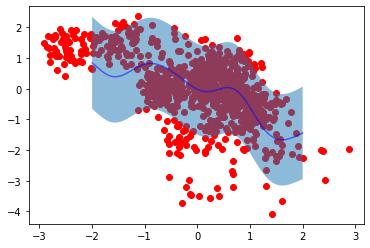

In [36]:
plt.scatter(output[:, 0], input[:, 0], c='r')
plt.plot(x_new, pred_f, c='b', alpha=0.5)
plt.fill_between(x_new[:, 0], (pred_f + 2 * np.sqrt(var_f))[:, 0], (pred_f - 2 * np.sqrt(var_f))[:, 0], alpha=0.5)
plt.show()

In [52]:
 - m_gpr.log_marginal_likelihood().numpy()

312.58301186061226

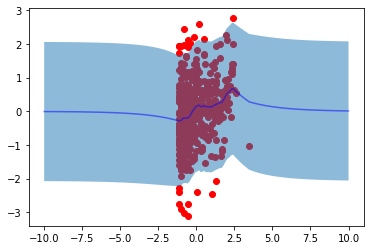

In [16]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.plot(x_new, pred_f, c='b', alpha=0.5)
plt.fill_between(x_new[:, 0], (pred_f + 2 * np.sqrt(var_f))[:, 0], (pred_f - 2 * np.sqrt(var_f))[:, 0], alpha=0.5)
plt.show()

In [17]:
- m_gpr.log_marginal_likelihood().numpy()

550.1637481854019

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

tf.config.list_physical_devices('GPU')

2022-06-20 14:12:04.259647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:12:04.273631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:12:04.273917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
tf.config.list_physical_devices('GPU')

2022-06-20 17:23:59.213218: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-20 17:23:59.213241: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: phlogiston.doc.ic.ac.uk
2022-06-20 17:23:59.213245: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: phlogiston.doc.ic.ac.uk
2022-06-20 17:23:59.213304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-06-20 17:23:59.213319: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-20 17:23:59.213323: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1


[]

In [32]:
from gpflow.base import Parameter
from gpflow.utilities import positive

import time


tf.config.run_functions_eagerly(False)

# for i in range(500):
# x, y, weight = get_synthetic_dataset(
#     num_datasets=100,
#     sample_size=100,
#     func_string="mult_a",
#     noise="uniform"
# )
# x = (x - x.mean(axis=1)[:, None, :]) / x.std(axis=1)[:, None, :]
# y = (y - y.mean(axis=1)[:, None, :]) / y.std(axis=1)[:, None, :]

# input, output = x[0], y[0]
start = time.time()


kernel_variance = 1.0
# Likelihood variance
kappa = np.random.uniform(
    low=1.0, high=32, size=[1]
)
# Kernel lengthscale
lamda = np.random.uniform(
    low=1.0, high=10, size=[2]
)

latent_dim = 1
num_inducing = 500

kernel_lengthscale = 1. / lamda
likelihood_variance = Parameter( 1. / (kappa ** 2), transform=positive(lower=1e-4))

print(f"Initial hyper: lengthscale - {kernel_lengthscale}, variance - {likelihood_variance.numpy()}")

sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[kernel_lengthscale[0]])
# rq_exp = gpflow.kernels.RationalQuadratic(lengthscales=[kernel_lengthscale[1]])

linear_kernel = gpflow.kernels.Linear(variance=kernel_variance)
sq_exp.variance.assign(kernel_variance)
# rq_exp.variance.assign(kernel_variance)

kernel = gpflow.kernels.Sum([sq_exp, linear_kernel])

m = gpflow.models.GPR(data=(input, output), kernel=kernel, mean_function=None)
m.likelihood.variance = likelihood_variance[0]
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=10000)
)
# found_lengthscales = [m.kernel.kernels[0].lengthscales.numpy(), m.kernel.kernels[1].lengthscales.numpy(), m.kernel.kernels[2].lengthscales.numpy()]
found_lengthscale_sq = m.kernel.kernels[0].lengthscales.numpy()[0]

found_kern_var_sq = m.kernel.kernels[0].variance.numpy()
found_kern_var_lin = m.kernel.kernels[1].variance.numpy()

found_lik_var = m.likelihood.variance.numpy()


sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[0.49868794, 1.1870421] )
# rq_exp = gpflow.kernels.RationalQuadratic(lengthscales=[found_lengthscale_rq] + [found_lengthscale_rq * 0.67])
linear_kernel = gpflow.kernels.Linear()

sq_exp.variance.assign(0.2555099222965678  )
# rq_exp.variance.assign(found_kern_var_rq)
linear_kernel.variance.assign(0.2080333867030226)
white_kern = gpflow.kernels.White()
 
kernel = gpflow.kernels.Sum([linear_kernel, sq_exp])


X_mean_init = output - m.predict_f(input)[0]

X_var_init = tf.cast(
    np.random.uniform(0, 0.1, (input.shape[0], latent_dim)), default_float()
)

m = PartObsBayesianGPLVM(
    data=output,
    in_data=input,
    kernel=kernel,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    num_inducing_variables=num_inducing,
    jitter=1e-5
)
m.likelihood.variance = Parameter( 0.03118006448279952, transform=positive(lower=1e-4))

# Train only inducing variables
tf.print("Training inducing")
gpflow.utilities.set_trainable(m.kernel, False)
gpflow.utilities.set_trainable(m.likelihood, False)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, False)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)
tf.print("ELBO:", - m.elbo())

# Train only x_var
tf.print("Training vars")
gpflow.utilities.set_trainable(m.kernel, False)
gpflow.utilities.set_trainable(m.likelihood, False)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, True)
gpflow.utilities.set_trainable(m.inducing_variable, True)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)
tf.print("ELBO:", - m.elbo())

# Train only means
tf.print("Training means")
gpflow.utilities.set_trainable(m.kernel, False)
gpflow.utilities.set_trainable(m.likelihood, False)
gpflow.utilities.set_trainable(m.X_data_mean , True)
gpflow.utilities.set_trainable(m.X_data_var, False)
gpflow.utilities.set_trainable(m.inducing_variable, True)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)
tf.print("ELBO:", - m.elbo())


# Train all the hyperparameters
tf.print("Training hyper")
gpflow.utilities.set_trainable(m.kernel, True)
gpflow.utilities.set_trainable(m.likelihood, True)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, False)
gpflow.utilities.set_trainable(m.inducing_variable, True)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)
tf.print("ELBO:", - m.elbo())

# Train everything
tf.print("Training everything")
gpflow.utilities.set_trainable(m.kernel, True)
gpflow.utilities.set_trainable(m.likelihood, True)
gpflow.utilities.set_trainable(m.X_data_mean , True)
gpflow.utilities.set_trainable(m.X_data_var, True)
gpflow.utilities.set_trainable(m.inducing_variable, True)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)
tf.print("ELBO:", - m.elbo())

loss = - m.elbo()

end = time.time()
print((end - start))


Initial hyper: lengthscale - [0.34374691 0.36190535], variance - [0.00852637]
Training inducing
ELBO: 9059.7767885801914
Training vars


In [ ]:
from gpflow.utilities import print_summary
print_summary(m)

╒═════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════╕
│ name                                                │ class     │ transform        │ prior   │ trainable   │ shape     │ dtype   │ value                        │
╞═════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════╡
│ PartObsBayesianGPLVM.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()        │ float64 │ 0.2555099222965678           │
├─────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────┤
│ PartObsBayesianGPLVM.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()        │ float64 │ 0.2080333867030226           │
├───────────────

In [ ]:
obs_new = np.linspace(-5, 5, 4000)[:, None]

Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
Xnew = tf.cast(Xnew, dtype=default_float())
Xnew = tf.concat(
    [obs_new, Xnew], axis=1
)
pred_f_mean, pred_f_var = m.predict_y(
    Xnew=Xnew,
)

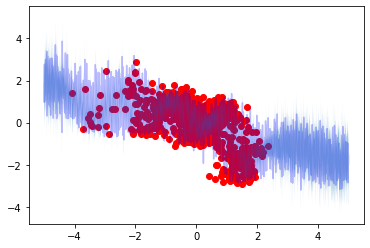

In [ ]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.25)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()

In [ ]:
-m.elbo().numpy()

1040.5716249252262

In [39]:
-m.elbo().numpy()

2022-06-20 12:37:39.104391: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-06-20 12:37:39.104528: E tensorflow/core/kernels/check_numerics_op.cc:293] abnormal_detected_host @0x7fa606011500 = {1, 0} LB is not finite!


InvalidArgumentError: LB is not finite! : Tensor had NaN values [Op:CheckNumerics]

In [18]:
from gpflow.utilities import print_summary
print_summary(m)

╒═══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════╕
│ name                              │ class     │ transform        │ prior   │ trainable   │ shape     │ dtype   │ value                │
╞═══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════╡
│ BayesianGPLVM.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()        │ float64 │ 3.3537760044870857   │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────┤
│ BayesianGPLVM.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()        │ float64 │ 2.582272150419165    │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────┤
│ BayesianGPLVM.likelihood.varianc

In [19]:
obs_new = np.linspace(-5, 5, 40)[:, None]
pred_y_mean, pred_y_var = m.predict_y(Xnew=obs_new)

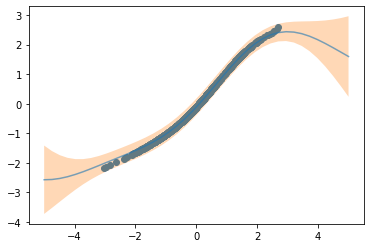

In [20]:
ind = np.argsort(m.X_data_mean[:, 0])
x_values = np.take_along_axis(m.X_data_mean.numpy()[:, 0], ind, axis=0)
# pred_y_mean_new = np.take_along_axis(pred_y_mean.numpy()[:, 0], ind, axis=0) 
# pred_y_var_new = np.take_along_axis(pred_y_var.numpy()[:, 0], ind, axis=0)

plt.scatter(m.X_data_mean, input)
plt.plot(obs_new, pred_y_mean, alpha=0.6)
plt.fill_between(obs_new[:, 0], (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0], (pred_y_mean - 2 * np.sqrt(pred_y_var))[:, 0], alpha=0.3)
plt.show()

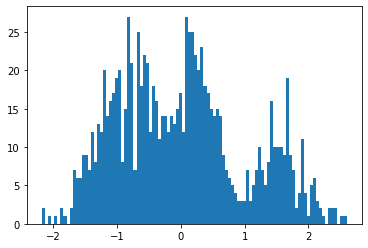

In [21]:
plt.hist(input, bins=100)
plt.show()

In [13]:
-m.elbo().numpy()

1408.8150497471183

In [23]:
-m.elbo().numpy()

1389.4006814392305

In [ ]:
407.47064394770905
391.04231501580705

In [98]:
from scipy.stats import norm
def ml_estimate(x):
    """
    Find the log likelihood.

    This doesn't make sense after I have normalised the data.
    """
    score = - np.sum( np.log(
            norm.pdf(x, loc=x.mean(), scale=x.std())

    ))
    print(norm.pdf(x, loc=x.mean(), scale=x.std()))
    return score

In [86]:
print( ml_estimate(x[2]), ml_estimate(y[2]), ml_estimate(np.random.normal(0, 1.5, 10000)))

[[0.2326027 ]
 [0.31852053]
 [0.13892459]
 ...
 [0.35506125]
 [0.39891987]
 [0.17203474]]
[[0.36215618]
 [0.38905551]
 [0.28767247]
 ...
 [0.3981433 ]
 [0.39889956]
 [0.258324  ]]
[0.17355695 0.26539336 0.1214141  ... 0.23633496 0.25741284 0.03818973]
14189.385332046726 14189.385332046728 18214.40122066285


In [8]:
tf.config.list_physical_devices('GPU')


[]

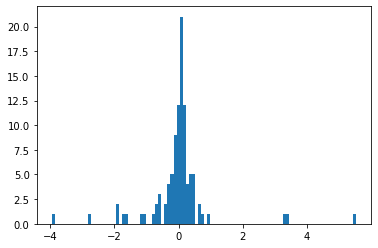

In [251]:
plt.hist(y[2], bins=100)
plt.show()

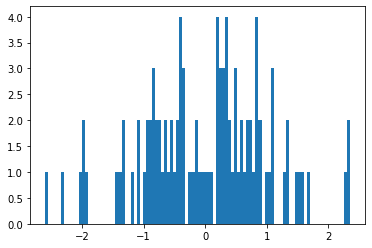

In [75]:
plt.hist(x[2], bins=100)
plt.show()

In [14]:
a = tf.Variable(1.0)
tf.debugging.check_numerics(a, message='')

b = tf.Variable(np.nan)
# try:
tf.debugging.check_numerics(b, message='Checking b')
# except Exception as e:
#   assert "Checking b : Tensor had NaN values" in e.message

c = tf.Variable(np.inf)
try:
  tf.debugging.check_numerics(c, message='Checking c')
except Exception as e:
  assert "Checking c : Tensor had Inf values" in e.message

InvalidArgumentError: Checking b : Tensor had NaN values [Op:CheckNumerics]

In [9]:
5541508.04182404 / 0.3

18471693.4727468

In [10]:
18471693.4727468

18471693.4727468

In [4]:
import tensorflow as tf
import gpflow
import gpflux
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_probability as tfp

num_data = input.shape[0]
NUM_INDUCING = 100
X = input
Y = output

w_dim = 1
prior_means = np.zeros(w_dim)
prior_std = np.ones(w_dim)
encoder = gpflux.encoders.DirectlyParameterizedNormalDiag(num_data, w_dim)
prior = tfp.distributions.MultivariateNormalDiag(prior_means, prior_std)
lv = gpflux.layers.LatentVariableLayer(prior, encoder)

/tmp/ipykernel_2943335/3648081335.py:18: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  encoder = gpflux.encoders.DirectlyParameterizedNormalDiag(num_data, w_dim)
2022-06-16 18:17:39.735563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 18:17:39.746724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 18:17:39.747388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had nega

In [5]:
kernel = gpflow.kernels.SquaredExponential(lengthscales=[.05, .2], variance=1.)
inducing_variable = gpflow.inducing_variables.InducingPoints(
np.concatenate(
    [
        np.linspace(X.min(), X.max(), NUM_INDUCING).reshape(-1, 1),
        np.random.randn(NUM_INDUCING, 1),
    ],
    axis=1
)
)
gp_layer = gpflux.layers.GPLayer(
kernel,
inducing_variable,
num_data=num_data,
num_latent_gps=1,
mean_function=gpflow.mean_functions.Zero(),
)

/homes/ad6013/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


In [6]:
kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.random.randn(NUM_INDUCING, 1),
)
gp_layer2 = gpflux.layers.GPLayer(
    kernel,
    inducing_variable,
    num_data=num_data,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Identity(),
)
gp_layer2.q_sqrt.assign(gp_layer.q_sqrt * 1e-5);

In [7]:
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))
gpflow.set_trainable(likelihood_layer, False)
dgp = gpflux.models.DeepGP([lv, gp_layer, gp_layer2], likelihood_layer)
gpflow.utilities.print_summary(dgp, fmt="notebook")

/tmp/ipykernel_2943335/481218405.py:1: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))
2022-06-16 18:17:40.893038: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._self_tracked_trackables[1]._trainable_weights[0] DeepGP.f_layers[0].encoder._trainable_weights[0],ResourceVariable,,,True,"(1000, 1)",float64,[[1.76405235e-02...
DeepGP.f_layers[0]._self_tracked_trackables[1]._trainable_weights[1] DeepGP.f_layers[0].encoder._trainable_weights[1],ResourceVariable,,,True,"(1000, 1)",float64,[[-11.51292046...
DeepGP.f_layers[0]._self_tracked_trackables[1]._self_tracked_trackables[0] DeepGP.f_layers[0]._self_tracked_trackables[1].means DeepGP.f_layers[0].encoder._self_tracked_trackables[0] DeepGP.f_layers[0].encoder.means,Parameter,Identity,,True,"(1000, 1)",float64,[[1.76405235e-02...
DeepGP.f_layers[0]._self_tracked_trackables[1]._self_tracked_trackables[1] DeepGP.f_layers[0]._self_tracked_trackables[1].stds DeepGP.f_layers[0].encoder._self_tracked_trackables[1] DeepGP.f_layers[0].encoder.stds,Parameter,Softplus,,True,"(1000, 1)",float64,[[1.e-05...
DeepGP.f_layers[1]._trainable_weights[0],ResourceVariable,,,True,"(100, 1)",float64,[[0....
DeepGP.f_layers[1]._trainable_weights[1],ResourceVariable,,,True,"(1, 5050)",float64,"[[1., 0., 0...."
DeepGP.f_layers[1]._self_tracked_trackables[1].variance DeepGP.f_layers[1].kernel.variance,Parameter,Softplus,,True,(),float64,1.0
DeepGP.f_layers[1]._self_tracked_trackables[1].lengthscales DeepGP.f_layers[1].kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.05 0.2 ]
DeepGP.f_layers[1]._self_tracked_trackables[2].Z DeepGP.f_layers[1].inducing_variable.Z,Parameter,Identity,,True,"(100, 2)",float64,"[[-2.8285247, 0.55596268..."
DeepGP.f_layers[1]._self_tracked_trackables[4] DeepGP.f_layers[1].q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[0....


In [8]:
model = dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.005))


In [9]:
history = model.fit({"inputs": X, "targets": Y}, epochs=int(20e3), verbose=0, batch_size=num_data, shuffle=False)

In [ ]:
gpflow.utilities.print_summary(dgp, fmt="notebook")
